In [1]:
# 导入所需的库
import platform  # 用于获取系统平台信息
import sys      # 用于获取Python解释器信息

# 打印Python环境信息
print("Python version:", sys.version)  # 打印Python版本
print("Platform:", platform.platform())  # 打印操作系统平台
print("System:", platform.system())  # 打印操作系统类型
print("Node:", platform.node())  # 打印网络节点名称
print("Release:", platform.release())  # 打印操作系统发行版本
print("Version:", platform.version())  # 打印操作系统版本号
print("Machine:", platform.machine())  # 打印计算机类型
print("Processor:", platform.processor())  # 打印处理器类型

# 检查TensorFlow版本及其依赖
!pip show tensorflow

# 检查系统硬件信息
!cat /proc/cpuinfo | grep 'model name'  # 显示CPU型号
!cat /proc/meminfo | grep 'MemTotal'    # 显示系统总内存
!df -h                                  # 显示磁盘使用情况
!nvidia-smi  # 如果有GPU，显示GPU信息


Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Platform: Windows-10-10.0.19041-SP0
System: Windows
Node: DESKTOP-61DGL33
Release: 10
Version: 10.0.19041
Machine: AMD64
Processor: AMD64 Family 23 Model 96 Stepping 1, AuthenticAMD
Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\anaconda\envs\tensorflow\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


'cat' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
'cat' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
'df' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
'nvidia-smi' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


# 数据集



## 数据集获取
 
本项目使用的蘑菇图像数据集托管在 [Kaggle](https://www.kaggle.com/) 平台上，数据集名称为 [huizecai/mushroom](https://www.kaggle.com/datasets/huizecai/mushroom)。该数据集包含了多种常见蘑菇的高清图片，以及对应的分类标签。

为了方便数据获取，我们使用 `kagglehub` 库来自动下载和管理数据集。下面的代码单元格会直接从 Kaggle 下载数据集，并返回保存在本地的路径。数据集下载完成后会被缓存，后续运行时将直接使用缓存版本，无需重复下载。

In [2]:
# 导入所需的库
import os  # 用于文件和目录操作
import kagglehub  # 用于从Kaggle下载数据集

# 设置数据集名称
dataset_name = "huizecai/mushroom"  # 指定要下载的Kaggle数据集名称

# 使用KaggleHub下载数据集
path = kagglehub.dataset_download(dataset_name)  # 下载数据集并获取保存路径

# 打印数据集文件的保存路径
print("Path to dataset files:", path)

# 设置数据和标签文件的具体路径
dataset_path = path + '/archive/data'  # 图片数据所在目录的路径
label_path = path + '/archive/label.txt'  # 标签文件的路径

c:\anaconda\envs\py3_11_11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\caijihuize\.cache\kagglehub\datasets\huizecai\mushroom\versions\5


## 数据集类别统计分析
 
为了避免TensorFlow处理中文路径时可能出现的编码问题，本数据集采用了规范化的命名方式:
 - 各蘑菇种类的文件夹以"classXX"格式命名(XX为数字编号)
 - 使用label.txt文件建立文件夹编号与中文名称的映射关系
 - 这种设计既保证了系统兼容性，又方便了数据的管理和使用

In [3]:
# 获取所有子目录（即蘑菇类别）
# os.listdir() 列出指定目录下的所有文件和文件夹
# os.path.isdir() 判断是否为文件夹
# 使用列表推导式获取所有蘑菇类别的文件夹名
dir_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# 读取 label.txt 并解析内容
# 创建一个空字典用于存储类别ID和名称的映射关系
categories = {}
# 以UTF-8编码打开label.txt文件
with open(label_path, 'r', encoding='utf-8') as file:
    for line in file:
        # 去除每行首尾空白字符并按空格分割
        parts = line.strip().split()
        # 确保每行包含两个部分:类别名称和ID
        if len(parts) == 2:
            category_name = parts[0]  # 第一部分为类别名称(中文)
            category_id = parts[1]    # 第二部分为类别ID
            categories[category_id] = category_name  # 建立ID到名称的映射

# 统计每种类别的图像数量
# 创建空字典存储每个类别的图片数量
category_counts = {}
for category_id in categories.keys():
    # 确保目录存在再进行统计
    if category_id in dir_names:
        # 构建完整的类别目录路径
        category_dir = os.path.join(dataset_path, category_id)
        # 统计jpg和jpeg格式的图片数量
        # 使用列表推导式过滤出图片文件并计数
        num_images = len([f for f in os.listdir(category_dir) if f.endswith('.jpg') or f.endswith('.jpeg')])
        # 使用中文类别名称作为键存储图片数量
        category_counts[categories[category_id]] = num_images

# 打印每个类别的图片数量统计结果
print("Category counts:", category_counts)

Category counts: {'羊肚菌': 170, '牛肝菌': 155, '鸡油菌': 153, '鸡枞菌': 165, '青头菌': 174, '奶浆菌': 182, '干巴菌': 156, '虎掌菌': 177, '白葱牛肝菌': 181, '老人头菌': 137, '猪肚菌': 109, '谷熟菌': 160, '白参菌': 171, '黑木耳': 174, '银耳': 127, '金耳': 157, '猴头菇': 176, '香菇': 168, '平菇': 161, '金针菇': 115, '口蘑': 139, '鹿茸菇': 154, '榆黄蘑': 177, '榛蘑': 172, '草菇': 149, '鸡腿菇': 137, '茶树菇': 159, '蟹味菇': 105, '白玉菇': 136, '红菇': 177, '杏鲍菇': 160, '松茸': 181, '姬松茸': 178, '松露': 151, '竹荪': 178, '虫草花': 177}


## 解决matplotlib中文显示问题

matplotlib默认不支持中文字体显示,可能会出现乱码。为了确保数据可视化结果能正确展示中文:
1. 我们将下载并使用"SimHei"(黑体)字体
2. 注册字体到matplotlib的字体管理器
3. 配置全局字体设置

这样可以保证后续所有图表中的中文标题、标签等都能正常显示。

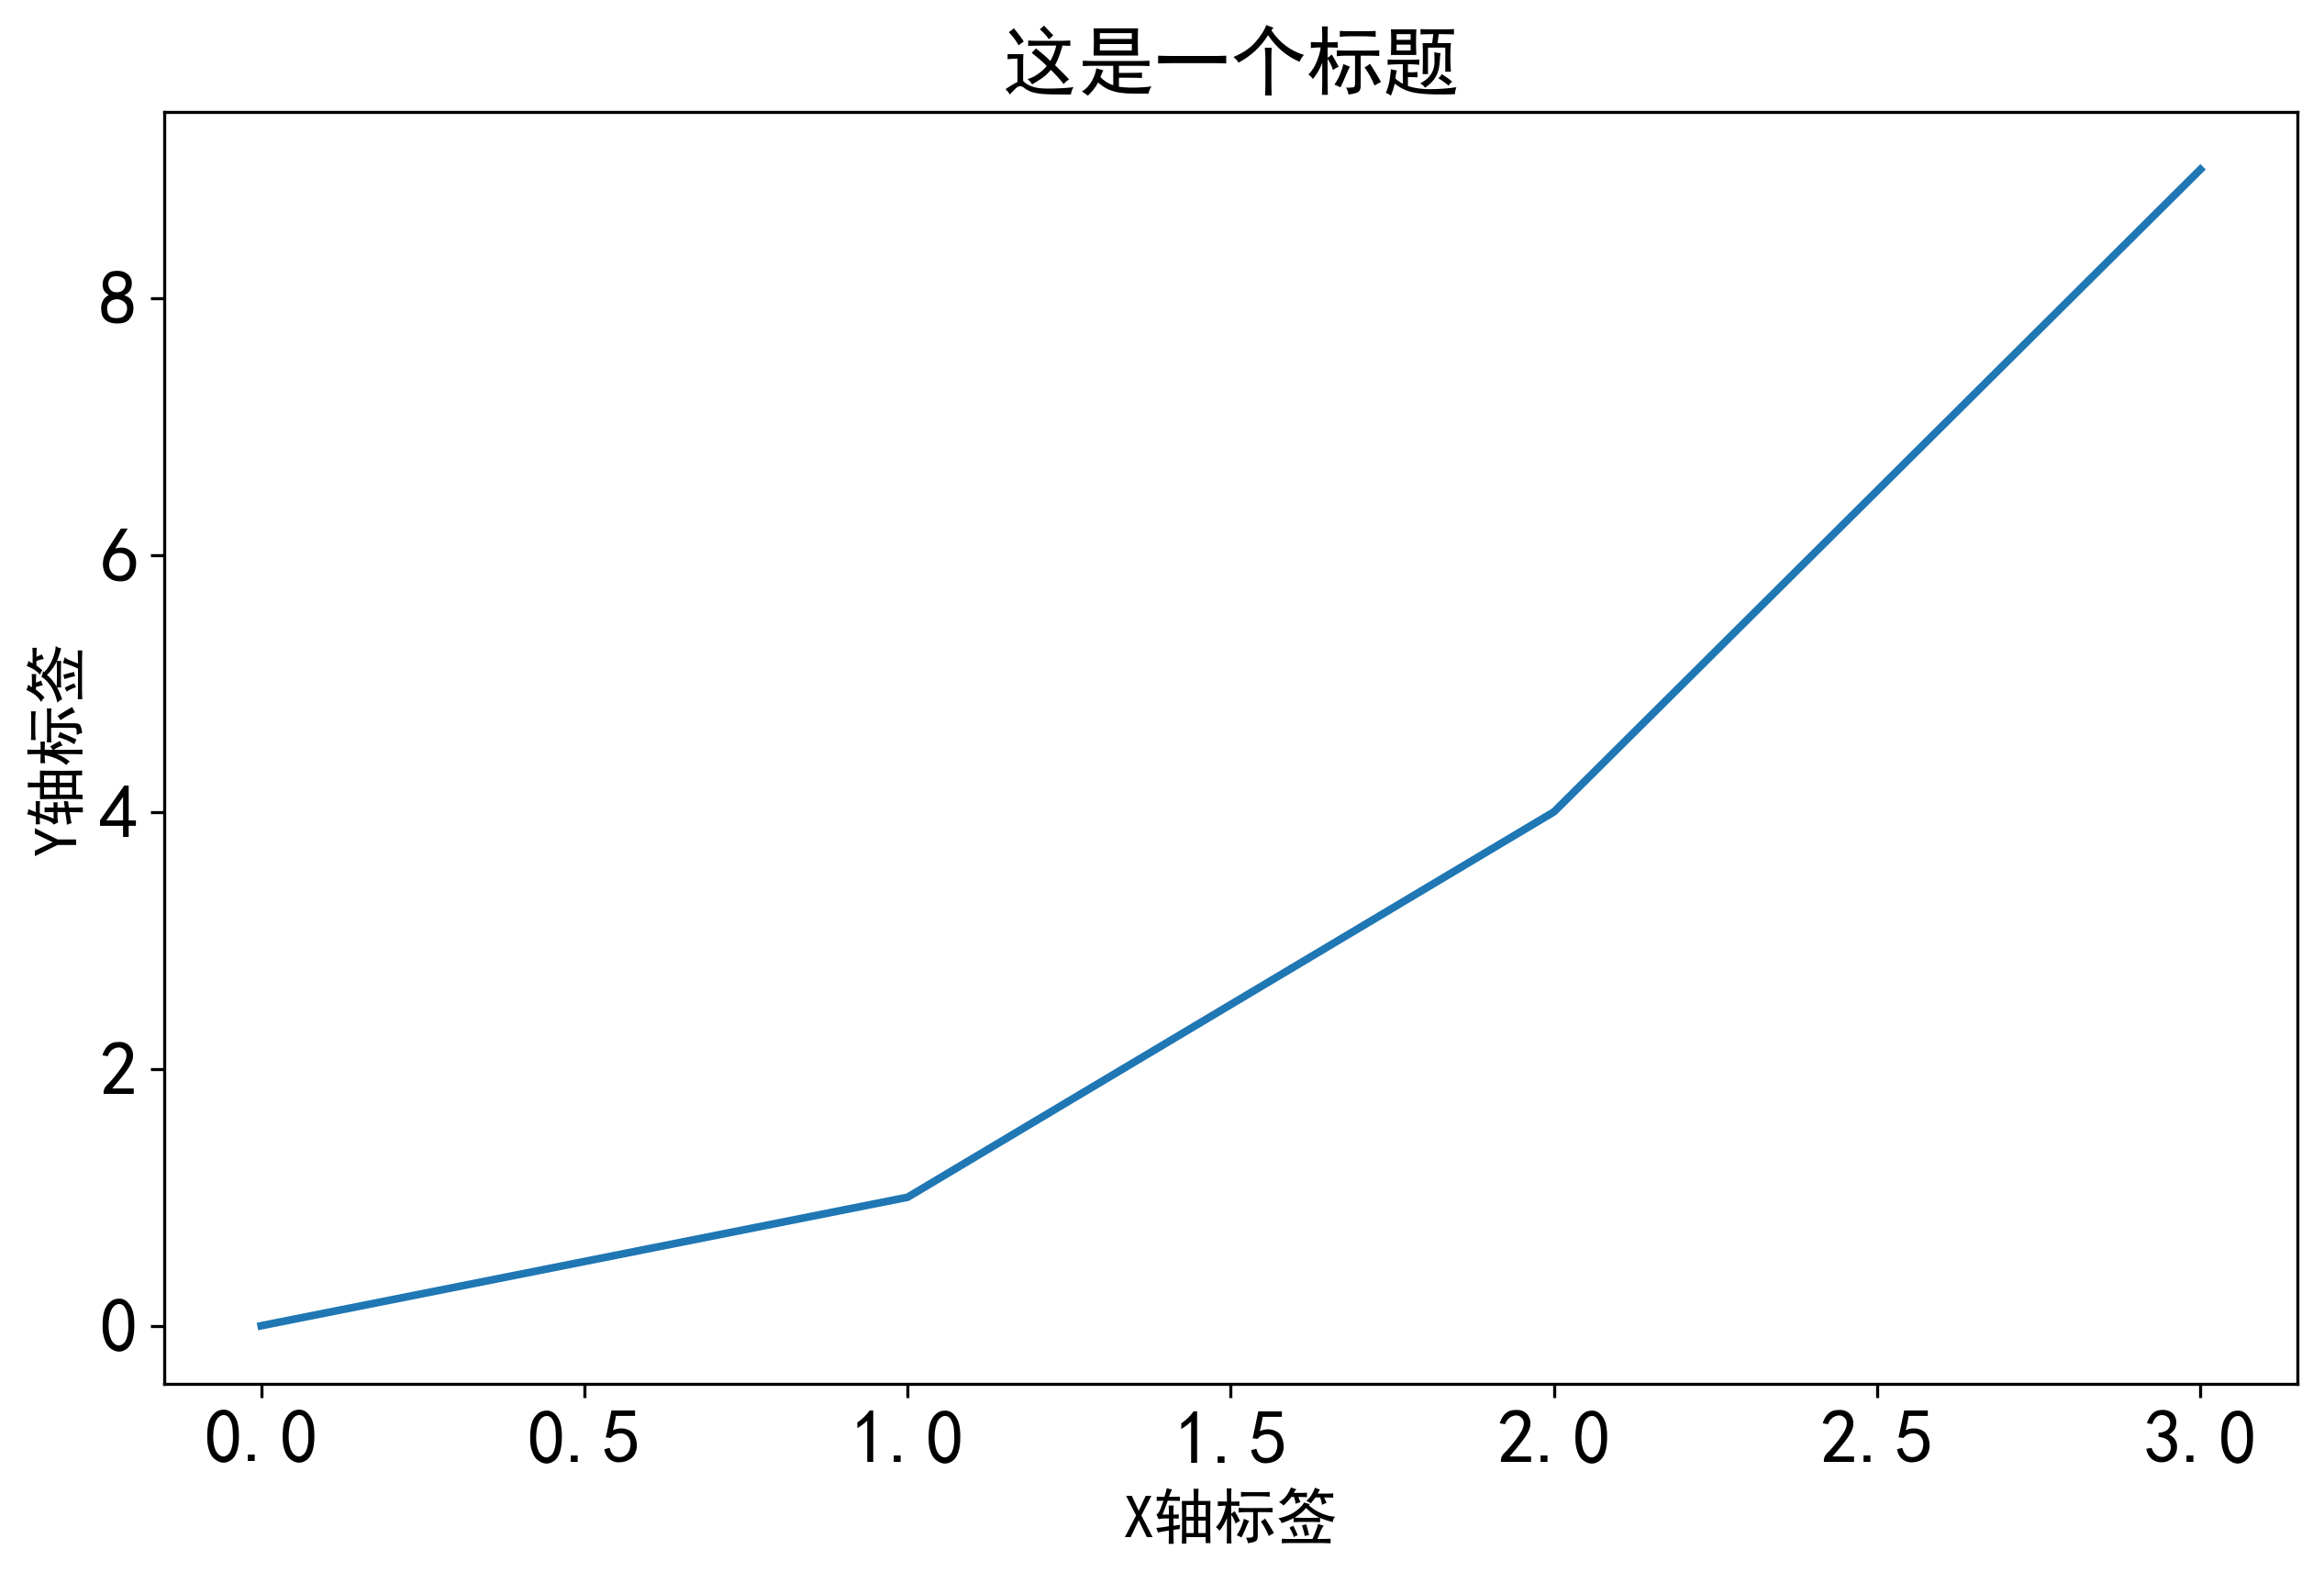

In [17]:
# 导入所需的库
import urllib.request  # 用于下载文件
import matplotlib.pyplot as plt  # 用于绘图
from matplotlib.font_manager import FontProperties, fontManager  # 用于字体管理
import os  # 用于文件操作
import numpy as np

# 创建img目录(如果不存在)
if not os.path.exists('img'):
    os.makedirs('img')

# 设置字体文件的URL和本地保存路径
font_url = "https://github.com/caijihuize/Mushroom_Classification/raw/main/SimHei.ttf"  # 黑体字体文件的URL
font_name = "SimHei.ttf"  # 本地保存的字体文件名

# 如果字体文件不存在则下载
if not os.path.exists(font_name):
    urllib.request.urlretrieve(font_url, font_name)  # 下载字体文件到本地

# 配置matplotlib的字体设置
fontManager.addfont(font_name)  # 将字体文件添加到matplotlib的字体管理器
font_prop = FontProperties(fname=font_name)  # 创建字体属性对象

# 设置全局字体配置
plt.rcParams['font.family'] = 'SimHei'  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['font.size'] = 20  # 设置全局字体大小
plt.rcParams['axes.titlesize'] = 22  # 设置标题字体大小
plt.rcParams['axes.labelsize'] = 20  # 设置轴标签字体大小
plt.rcParams['figure.dpi'] = 300  # 设置图形DPI为300,提高显示清晰度
plt.rcParams['savefig.dpi'] = 600  # 设置保存图片的DPI为600,提高保存图片的清晰度

# 绘制测试图表验证中文显示
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.title('这是一个标题', fontsize=20)  # 设置标题
plt.xlabel('X轴标签', fontsize=16)  # 设置X轴标签
plt.ylabel('Y轴标签', fontsize=16)  # 设置Y轴标签
plt.plot([0, 1, 2, 3], [0, 1, 4, 9], linewidth=2)  # 绘制简单的折线图,增加线宽提高清晰度

# 保存图表到img目录,使用更高质量的设置
plt.savefig('img/test_plot.png', 
            bbox_inches='tight',  # 自动调整边界
            dpi=800,  # 设置更高的DPI
            format='png',  # 使用PNG格式保存
            facecolor='white',  # 设置白色背景
            edgecolor='none',  # 无边框
            transparent=False)  # 不透明
plt.show()  # 显示图表

## 绘制各种类图片数量的柱状图

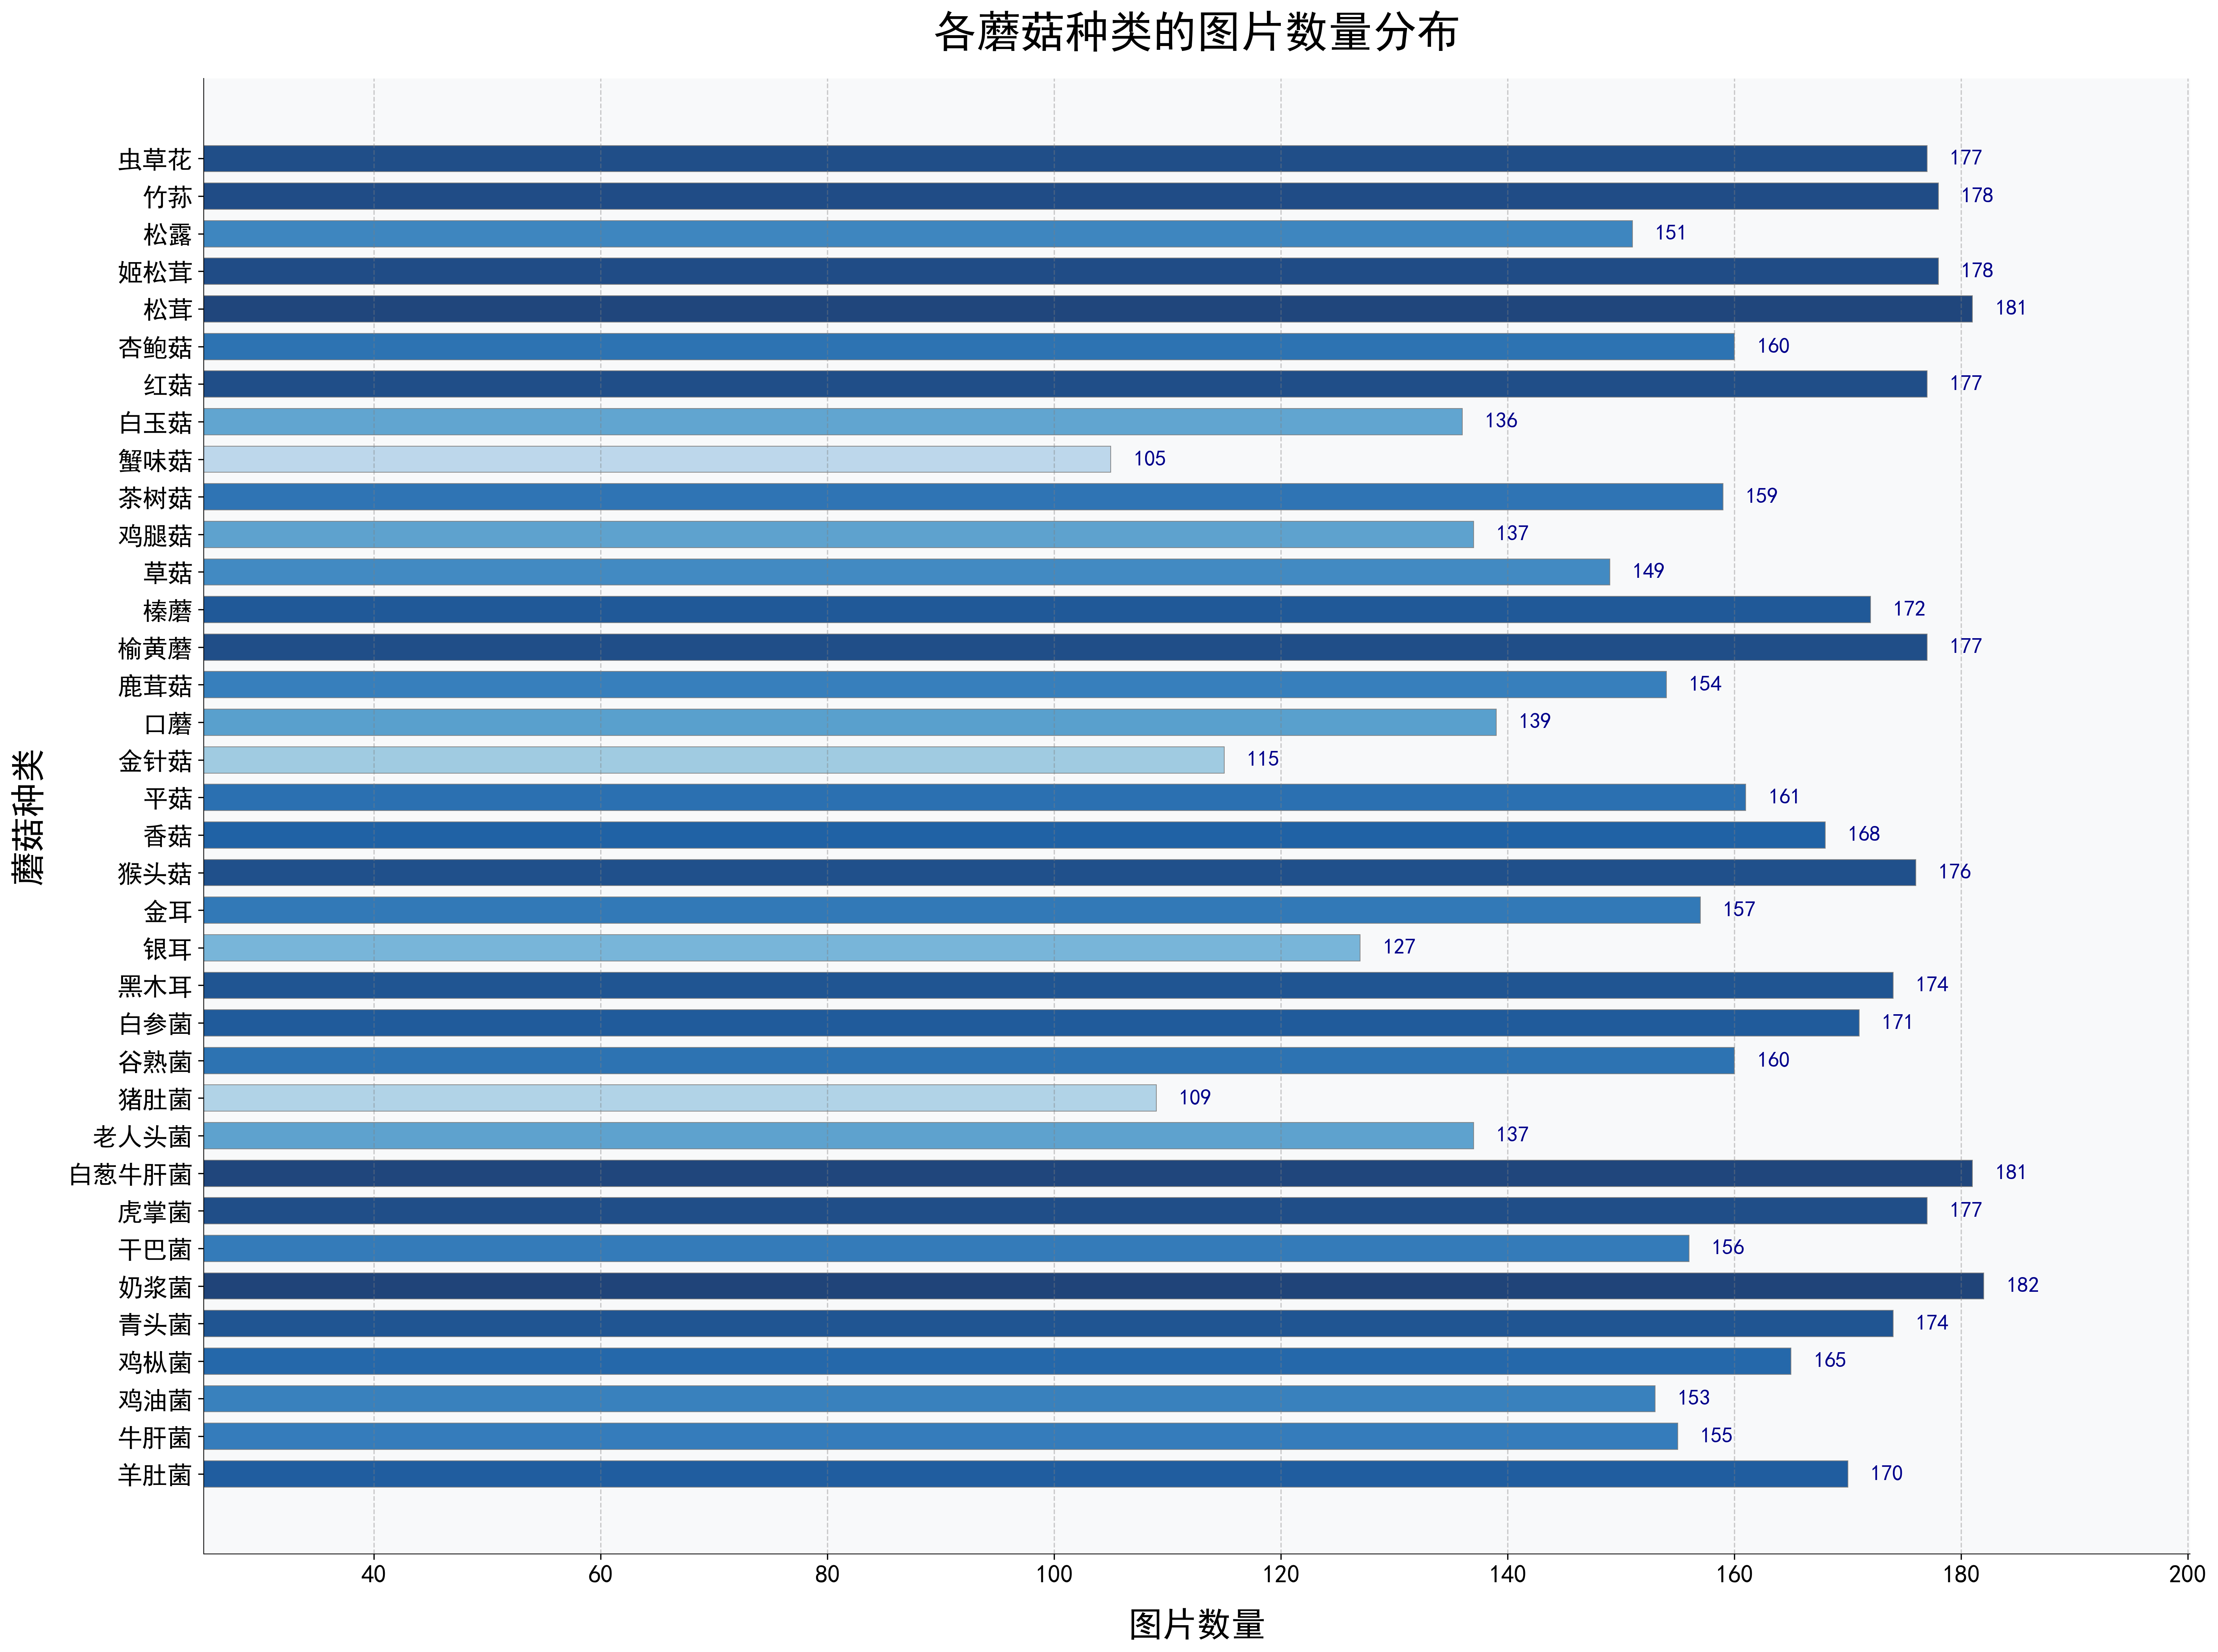

In [22]:
# 准备数据
categories_readable = list(category_counts.keys())  # 获取所有蘑菇种类名称
counts = list(category_counts.values())  # 获取每个种类对应的图片数量

# 创建一个新的图形，设置更大的尺寸以便更好地展示数据
plt.figure(figsize=(20, 15))

# 创建颜色渐变 - 根据数量排序，数量越多颜色越亮
# 首先创建数量和类别的映射关系
count_category_pairs = list(zip(counts, categories_readable))
# 按照数量排序
count_category_pairs.sort(key=lambda x: x[0])
# 提取排序后的类别和数量
sorted_categories = [pair[1] for pair in count_category_pairs]
sorted_counts = [pair[0] for pair in count_category_pairs]

# 创建颜色映射，使用较为柔和的颜色差异
# 使用单一色系的渐变，减小颜色差异
norm = plt.Normalize(min(counts), max(counts))
# 使用Blues色系，颜色差异较小
colors = plt.cm.Blues(norm(counts) * 0.7 + 0.3)  # 缩小颜色范围，增加最小值，减小颜色差异

# 绘制水平柱状图，使用柔和的颜色
bars = plt.barh(categories_readable, counts, color=colors, height=0.7, 
                edgecolor='gray', linewidth=0.5, alpha=0.9)  # 增加透明度使颜色更柔和

# 在每个柱子右侧添加数值标签
for i, bar in enumerate(bars):
    width = bar.get_width()  # 获取柱子的宽度(即图片数量)
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             va='center', ha='left', fontsize=14, fontweight='bold', 
             color='darkblue')  # 美化标签样式

# 设置图表标题和轴标签
plt.title('各蘑菇种类的图片数量分布', fontsize=28, fontweight='bold', pad=20)  # 增大标题字体并加粗
plt.xlabel('图片数量', fontsize=22, labelpad=15)  # 设置x轴标签并增加内边距
plt.ylabel('蘑菇种类', fontsize=22, labelpad=15)  # 设置y轴标签并增加内边距

# 设置坐标轴样式
plt.tick_params(axis='both', which='major', labelsize=16)  # 增大刻度标签字体
plt.xlim(25, max(counts) + max(counts)*0.1)  # 设置x轴范围，留出更多空间

# 添加网格线
plt.grid(axis='x', linestyle='--', alpha=0.4, color='gray')  # 使用更淡的网格线

# 添加背景色
plt.gca().set_facecolor('#f8f9fa')  # 设置浅灰色背景
plt.gca().spines['top'].set_visible(False)  # 移除上边框
plt.gca().spines['right'].set_visible(False)  # 移除右边框
plt.gca().spines['left'].set_linewidth(0.5)  # 减小左边框宽度
plt.gca().spines['bottom'].set_linewidth(0.5)  # 减小下边框宽度

# 自动调整布局，防止标签被截断
plt.tight_layout()

# 保存图表到img目录，使用更高质量的设置
plt.savefig('img/mushroom_distribution.png', 
            bbox_inches='tight', 
            dpi=800, 
            facecolor='#f8f9fa')  # 保存高质量图片，保持背景色一致

# 显示图形
plt.show()

# 训练准备工作

## 加载图像数据集

使用 TensorFlow 的 [image_dataset_from_directory](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?hl=en) 函数加载和准备图像数据集：


*   directory=dataset_path ：指定图像数据所在的路径。
*   image_size=(224, 224) ：指定每个图像的大小为224x224像素。
*   batch_size=32 ：指定每个批次包含32张图像。
*   validation_split=0.1 ：指定10%的数据作为验证集。
*   subset='both' ：指定同时返回训练集和验证集。
*   label_mode='categorical' ：指定标签模式为分类模式，返回one-hot编码的标签。
*   seed=21 ：设置随机种子以确保数据集的可重复性。



In [ ]:
import tensorflow as tf

# 加载和准备图像数据集
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.1,
    subset='both',
    label_mode='categorical',
    seed=44
)

## 计算训练集和验证集的各种类图片分布

In [ ]:
import numpy as np

# 获取类别名称
class_names = train_dataset.class_names

# 初始化字典用于存储每种类别的图像数量
train_category_counts = {name: 0 for name in categories.values()}
validation_category_counts = {name: 0 for name in categories.values()}

# 统计训练集中的图像数量
for images, labels in train_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        train_category_counts[categories[category_name]] += 1

# 统计验证集中的图像数量
for images, labels in validation_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        validation_category_counts[categories[category_name]] += 1


print("训练集类别图像数量统计:", train_category_counts)
print("验证集类别图像数量统计:", validation_category_counts)

## 绘制训练集和验证集的柱状图

In [ ]:
# 准备数据
categories_readable = list(categories.values())  # 使用中文名映射
train_counts = [train_category_counts[name] for name in categories_readable]
validation_counts = [validation_category_counts[name] for name in categories_readable]

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 设置柱子的位置
bar_width = 0.35
index = np.arange(len(categories_readable))

# 绘制训练集柱状图
bars_train = plt.barh(index + bar_width, train_counts, bar_width, label='训练集', color='skyblue')

# 绘制验证集柱状图
bars_validation = plt.barh(index, validation_counts, bar_width, label='测试集', color='orange')

# 添加数据标签
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2, '%d' % int(width), ha='left', va='center')

add_labels(bars_train)
add_labels(bars_validation)

# 设置标题和标签
plt.title('各蘑菇种类的图片数量 (Train vs Validation)', fontsize=20)
plt.xlabel('图片数量', fontsize=16)
plt.ylabel('蘑菇种类', fontsize=16)

# 设置Y轴刻度
plt.yticks(index + bar_width / 2, categories_readable)

# 显示网格
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 添加图例
plt.legend()

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

## 显示数据集中的图像样本

In [ ]:
# 获取类别名称
class_names = train_dataset.class_names

# 设置要显示的图像数量
num_images_to_show = 4
images_to_display = []
labels_to_display = []

# 从数据集中获取随机选择的图像和标签
for images, labels in train_dataset.take(1):
    indices = np.random.choice(range(images.shape[0]), num_images_to_show, replace=False)
    for index in indices:
        images_to_display.append(images[index])
        labels_to_display.append(labels[index])

# 创建图形并显示图像
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 4))
for i, (image, label) in enumerate(zip(images_to_display, labels_to_display)):
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.set_title(categories[class_names[np.argmax(label.numpy())]], fontsize=20)
    ax.axis("off")

plt.tight_layout()
plt.show()

# 数据增强

数据增强是一种常用的技术，用于通过变换现有数据来增加训练数据的多样性，从而提高模型的泛化能力。在图像处理中，常见的数据增强技术包括旋转、翻转、缩放、裁剪、亮度调整等。

## 定义数据增强层

In [10]:
# 定义数据增强的预处理层
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # 水平翻转
    tf.keras.layers.RandomRotation(0.2),       # 随机旋转最多20%
    tf.keras.layers.RandomZoom(0.2, 0.2),      # 随机缩放
    tf.keras.layers.RandomContrast(0.2),       # 随机对比度调整
    tf.keras.layers.RandomBrightness(0.2)      # 随机亮度调整
])

## 定义显示数据增强示例函数

In [11]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

## 获取随机批次

In [ ]:
# 获取训练集中随机的一批次图片
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

## 显示数据增强示例

In [ ]:
NUM_AUG = 5

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# 常用显示函数

In [14]:
# 训练模型
def train_model(model, train_dataset=train_dataset, validation_dataset=validation_dataset, epochs=30):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

    history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[early_stopping, lr_scheduler])

    return history

In [15]:
# 量化与格式转换
def quantize_and_convert_to_tflite(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_quant_model = converter.convert()

    return tflite_quant_model

def save_model(model, output_path):
  with open(output_path, 'wb') as f:
    f.write(model)

In [16]:
def show_history(history):
  # 绘制训练过程中的损失和准确率曲线
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [17]:
def combine_history(histories, labels):
  min_epochs = min([len(history.history['loss']) for history in histories])
  epochs = range(1, min_epochs + 1)

  plt.figure(figsize=(14, 6))

  # (1) 绘制损失曲线
  plt.subplot(1, 2, 1)
  for i, history in enumerate(histories):
      train_loss = history.history['loss'][:min_epochs]
      val_loss = history.history['val_loss'][:min_epochs]
      plt.plot(epochs, train_loss, label=f'{labels[i]} Train Loss', linestyle='--')
      plt.plot(epochs, val_loss, label=f'{labels[i]} Val Loss')

  plt.title('Training and Validation Loss Comparison')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  # (2) 绘制准确率曲线（如果需要）
  plt.subplot(1, 2, 2)
  for i, history in enumerate(histories):
      train_acc = history.history['accuracy'][:min_epochs]
      val_acc = history.history['val_accuracy'][:min_epochs]
      plt.plot(epochs, train_acc, label=f'{labels[i]} Train Accuracy', linestyle='--')
      plt.plot(epochs, val_acc, label=f'{labels[i]} Val Accuracy')

  plt.title('Training and Validation Accuracy Comparison')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  # 显示图表
  plt.tight_layout()
  plt.show()

In [18]:
from IPython.display import clear_output

# 在训练完成后计算每个类别的准确率
def calculate_class_accuracies(model, dataset):
    all_predictions = []
    all_true_labels = []

    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        all_predictions.extend(predicted_classes)
        all_true_labels.extend(true_classes)

    class_accuracies = {}
    for class_index in range(len(class_names)):
        mask = (np.array(all_true_labels) == class_index)
        correct_predictions = np.sum(np.array(all_predictions)[mask] == class_index)
        total_samples = np.sum(mask)
        if total_samples > 0:
            accuracy = correct_predictions / total_samples
        else:
            accuracy = 0
        class_accuracies[class_names[class_index]] = accuracy

    clear_output(wait=True)

    # 准备数据
    categories_readable = list(categories[class_name] for class_name in class_accuracies.keys())
    accuracies = list(class_accuracies.values())

    # 创建一个新的图形
    plt.figure(figsize=(14, 8))

    # 绘制柱状图
    bars = plt.barh(categories_readable, accuracies, color='skyblue')

    # 添加数据标签
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

    # 设置标题和标签
    plt.title('各类别准确率', fontsize=20)
    plt.xlabel('准确率', fontsize=16)
    plt.ylabel('类别', fontsize=16)

    # 设置网格
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # 自动调整布局
    plt.tight_layout()

    # 显示图形
    plt.show()

    return class_accuracies

In [32]:
def evaluate_model(model, dataset):
        """使用TensorFlow内置metrics评估Keras模型在数据集上的性能"""
        # 计算模型大小 (MB)
        model_size_mb = sum(np.prod(w.shape) for w in model.get_weights()) * 4 / (1024 * 1024)  # 假设浮点数为4字节

        # 创建评估指标
        top1_accuracy = tf.keras.metrics.CategoricalAccuracy()
        top5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')

        # 在数据集上运行评估
        loss_object = tf.keras.losses.CategoricalCrossentropy()
        loss_avg = tf.keras.metrics.Mean()

        for images, labels in dataset:
            predictions = model(images, training=False)
            loss = loss_object(labels, predictions)

            loss_avg.update_state(loss)
            top1_accuracy.update_state(labels, predictions)
            top5_accuracy.update_state(labels, predictions)

        # 获取结果
        loss = loss_avg.result().numpy()
        top1 = top1_accuracy.result().numpy()
        top5 = top5_accuracy.result().numpy()

        print(f"Loss: {loss:.4f}")
        print(f"Top-1 Accuracy: {top1:.4f}")
        print(f"Top-5 Accuracy: {top5:.4f}")
        print(f"Model Size: {model_size_mb:.2f} MB")

        return top1, top5, model_size_mb

def evaluate_tflite_model(tflite_model, dataset):
    """使用TensorFlow Lite工具简化的评估函数"""
    # 计算TFLite模型大小 (MB)
    model_size_mb = len(tflite_model) / (1024 * 1024)

    # 创建TFLite解释器
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    # 获取输入输出细节
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # 创建评估指标
    top1_accuracy = tf.keras.metrics.Accuracy()
    top5_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)

    # 评估进度计数器
    total_samples = 0

    # 遍历数据集
    for images, labels in dataset:
        # 获取标签的真实类别（稀疏形式）
        true_labels = tf.argmax(labels, axis=1).numpy()

        batch_size = images.shape[0]
        batch_predictions = np.zeros((batch_size, len(class_names)), dtype=np.float32)

        # 逐个样本进行推理
        for i in range(batch_size):
            total_samples += 1

            # 预处理输入
            input_data = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)

            # 设置输入张量
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # 运行推理
            interpreter.invoke()

            # 获取输出并保存
            batch_predictions[i] = interpreter.get_tensor(output_details[0]['index'])[0]

        # 更新指标（整个批次一次更新）
        top1_accuracy.update_state(
            true_labels,
            np.argmax(batch_predictions, axis=1)
        )
        top5_accuracy.update_state(
            true_labels,
            batch_predictions
        )

    # 获取结果
    top1 = top1_accuracy.result().numpy()
    top5 = top5_accuracy.result().numpy()

    print(f"TFLite模型 Top-1 准确率: {top1:.4f}")
    print(f"TFLite模型 Top-5 准确率: {top5:.4f}")
    print(f"TFLite模型大小: {model_size_mb:.2f} MB")

    return top1, top5, model_size_mb

# MobileNetV1模型

In [19]:
def get_MobileNetV1():
  # 初始化基础模型
  pre_trained_model = tf.keras.applications.MobileNet(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet'
  )

  # 冻结基础模型的权重
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)
  x = tf.keras.applications.mobilenet.preprocess_input(x)

  # 添加自定义顶层分类器
  x = pre_trained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

  # 构建最终模型
  MobileNetV1 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return MobileNetV1

# MobileNetV2模型

In [20]:
def get_MobileNetV2():
  # 初始化基础模型
  pre_trained_model = tf.keras.applications.MobileNetV2(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet'
  )

  # 冻结基础模型的权重
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)
  x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

  # 添加自定义顶层分类器
  x = pre_trained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

  # 构建最终模型
  MobileNetV2 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return MobileNetV2

# EfficientNet模型

In [21]:
def get_EfficientNetB0():
  # 初始化基础模型
  pre_trained_model = tf.keras.applications.EfficientNetB0(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet'
  )

  # 冻结基础模型的权重
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)
  x = tf.keras.applications.efficientnet.preprocess_input(x)

  # 添加自定义顶层分类器
  x = pre_trained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

  # 构建最终模型
  EfficientNetB0 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return EfficientNetB0

# ResNet模型

In [22]:
def get_ResNet101():
  # 初始化基础模型
  pre_trained_model = tf.keras.applications.ResNet101(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet'
  )

  # 冻结基础模型的权重
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)
  x = tf.keras.applications.resnet.preprocess_input(x)

  # 添加自定义顶层分类器
  x = pre_trained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

  # 构建最终模型
  ResNet101 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return ResNet101

# 训练

In [ ]:
MobileNetV1 = get_MobileNetV1()
show_history(train_model(MobileNetV1))
MobileNetV1_tflite = quantize_and_convert_to_tflite(MobileNetV1)

In [ ]:
MobileNetV2 = get_MobileNetV2()
show_history(train_model(MobileNetV2))
MobileNetV2_tflite = quantize_and_convert_to_tflite(MobileNetV2)

In [ ]:
EfficientNetB0 = get_EfficientNetB0()
show_history(train_model(EfficientNetB0))
EfficientNetB0_tflite = quantize_and_convert_to_tflite(EfficientNetB0)

In [ ]:
ResNet101 = get_ResNet101()
show_history(train_model(ResNet101))
ResNet101_tflite = quantize_and_convert_to_tflite(ResNet101)

# 评估

In [ ]:
print("MobileNetV1:\n")
evaluate_model(MobileNetV1, validation_dataset)
evaluate_tflite_model(MobileNetV1_tflite, validation_dataset)
save_model(MobileNetV1_tflite, "MobileNetV1.tflite")

print("\nMobileNetV2:\n")
evaluate_model(MobileNetV2, validation_dataset)
evaluate_tflite_model(MobileNetV2_tflite, validation_dataset)
save_model(MobileNetV2_tflite, "MobileNetV2.tflite")

print("\nEfficientNetB0:\n")
evaluate_model(EfficientNetB0, validation_dataset)
evaluate_tflite_model(EfficientNetB0_tflite, validation_dataset)
save_model(nEfficientNetB0_tflite, "nEfficientNetB0.tflite")

print("\nResNet101:\n")
evaluate_model(ResNet101, validation_dataset)
evaluate_tflite_model(ResNet101_tflite, validation_dataset)
save_model(ResNet101_tflite, "ResNet101.tflite")
